In [ ]:
pip install git+https://github.com/IBM/LNN

  Cloning https://github.com/IBM/LNN to /tmp/pip-req-build-36l6vhxc
  Running command git clone --filter=blob:none --quiet https://github.com/IBM/LNN /tmp/pip-req-build-36l6vhxc
  Resolved https://github.com/IBM/LNN to commit 2382067d91b5cba67ce90817925e6e70bc84f25a
  Preparing metadata (setup.py) ... done


   obj. no.    Name Colour        center
0         1  bottle   pink   (0.7, 0.25)
1         2  bucket  green  (0.67, 0.05)
2         3    ball  brown  (0.33, 0.68)
3         4     toy  green   (0.5, 0.84)
4         5     cap    red  (0.81, 0.63)
5         6     cap   grey  (0.16, 0.38)
6         7     cup   blue  (0.37, 0.74)
{1: ('bottle', 'pink', (0.7, 0.25)), 2: ('bucket', 'green', (0.67, 0.05)), 3: ('ball', 'brown', (0.33, 0.68)), 4: ('toy', 'green', (0.5, 0.84)), 5: ('cap', 'red', (0.81, 0.63)), 6: ('cap', 'grey', (0.16, 0.38)), 7: ('cup', 'blue', (0.37, 0.74))}


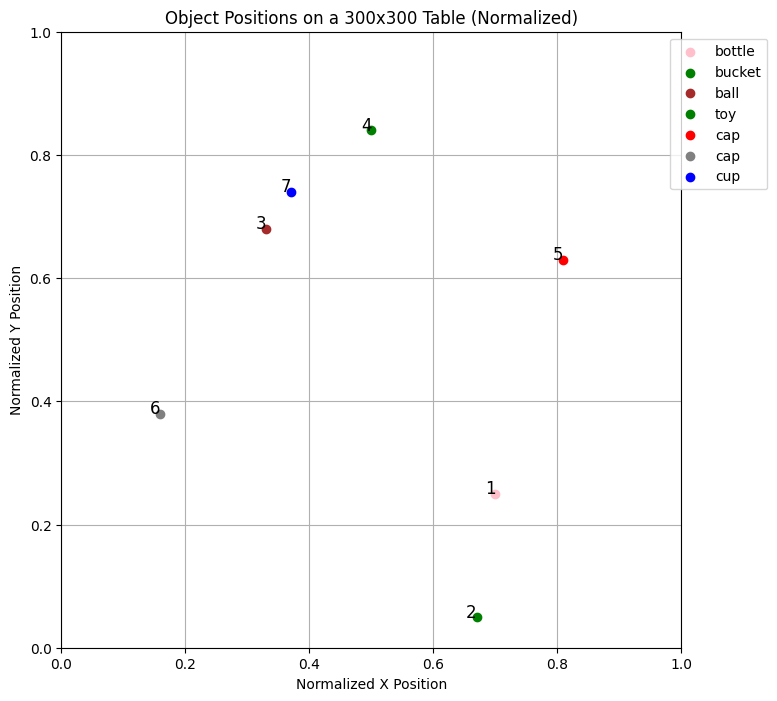

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the object data
objects = ['bottle', 'toy', 'cap', 'cap', 'cup', 'bucket', 'ball']
colours = ['red', 'green', 'green', 'blue', 'pink', 'grey', 'brown']

# Shuffle the objects and colors
np.random.seed()  # Ensures different results each time
np.random.shuffle(objects)
np.random.shuffle(colours)

# Generate random center positions (normalized)
table_size = 300
center_x = np.random.uniform(0, table_size, 7) / table_size
center_y = np.random.uniform(0, table_size, 7) / table_size
centers = [(round(x, 2), round(y, 2)) for x, y in zip(center_x, center_y)]

# Create the data dictionary
data = {
    'obj. no.': range(1, 8),
    'Name': objects,
    'Colour': colours,
    'center': centers
}

# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

# Store the output in the desired format for LNN model
object_data = {row['obj. no.']: (row['Name'], row['Colour'], row['center']) for idx, row in df.iterrows()}

# Display the object_data dictionary
print(object_data)

# Visualize the positions
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_title("Object Positions on a 300x300 Table (Normalized)")

# Plot each object
for idx, row in df.iterrows():
    ax.scatter(row['center'][0], row['center'][1], label=row['Name'], color=row['Colour'])
    ax.text(row['center'][0], row['center'][1], f"{row['obj. no.']}", fontsize=12, ha='right')

ax.set_xlabel("Normalized X Position")
ax.set_ylabel("Normalized Y Position")
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

plt.grid(True)
plt.show()


In [ ]:
from lnn import Predicate, Variable, Fact, Implies, Model, World, And
import pandas as pd
import numpy as np

# Define the predicates for object properties and relations
Obj = Predicate('Obj', arity=1)   # Object with specific properties
LeftOf = Predicate('LeftOf', arity=2)  # Relation: left of another object
RightOf = Predicate('RightOf', arity=2)  # Relation: right of another object
UpOf = Predicate('UpOf', arity=2)  # Relation: up of another object
DownOf = Predicate('DownOf', arity=2)  # Relation: down of another object
TopLeftOf = Predicate('TopLeftOf', arity=2)  # Relation: top-left of another object
TopRightOf = Predicate('TopRightOf', arity=2)  # Relation: top-right of another object
BottomLeftOf = Predicate('BottomLeftOf', arity=2)  # Relation: bottom-left of another object
BottomRightOf = Predicate('BottomRightOf', arity=2)  # Relation: bottom-right of another object

# Define variables
x, y = Variable('x'), Variable('y')

# Create a model
model = Model()

# Add the predicates to the model
model.add_knowledge(Obj, LeftOf, RightOf, UpOf, DownOf, TopLeftOf, TopRightOf, BottomLeftOf, BottomRightOf)


# Add object properties to the model
obj_data = {('{}'.format(obj_no),): Fact.TRUE for obj_no in object_data}

# Add the object data to the model
model.add_data({Obj: obj_data})

# Define the relationships (left of, right of, up of, down of)
left_relations = {}
right_relations = {}
up_relations = {}
down_relations = {}

for obj1, (_, _, pos1) in object_data.items():
    for obj2, (_, _, pos2) in object_data.items():
        if obj1 != obj2:
            if pos1[0] < pos2[0]:  # If obj1 is to the left of obj2
                left_relations[(str(obj1), str(obj2))] = Fact.TRUE
            if pos1[0] > pos2[0]:  # If obj1 is to the right of obj2
                right_relations[(str(obj1), str(obj2))] = Fact.TRUE
            if pos1[1] < pos2[1]:  # If obj1 is below obj2
                up_relations[(str(obj1), str(obj2))] = Fact.TRUE
            if pos1[1] > pos2[1]:  # If obj1 is above obj2
                down_relations[(str(obj1), str(obj2))] = Fact.TRUE

# Add the relations data to the model
model.add_data({
    LeftOf: left_relations,
    RightOf: right_relations,
    UpOf: up_relations,
    DownOf: down_relations
})

# Define the composite relationships (TopLeftOf, TopRightOf, BottomLeftOf, BottomRightOf)
top_left_relations = {}
top_right_relations = {}
bottom_left_relations = {}
bottom_right_relations = {}

for (obj1, obj2) in left_relations:
    if up_relations.get((obj1, obj2), False):
        top_left_relations[(str(obj1), str(obj2))] = Fact.TRUE
    if down_relations.get((obj1, obj2), False):
        bottom_left_relations[(str(obj1), str(obj2))] = Fact.TRUE

for (obj1, obj2) in right_relations:
    if up_relations.get((obj1, obj2), False):
        top_right_relations[(str(obj1), str(obj2))] = Fact.TRUE
    if down_relations.get((obj1, obj2), False):
        bottom_right_relations[(str(obj1), str(obj2))] = Fact.TRUE

# Add the composite relations data to the model
model.add_data({
    TopLeftOf: top_left_relations,
    TopRightOf: top_right_relations,
    BottomLeftOf: bottom_left_relations,
    BottomRightOf: bottom_right_relations
})

# Define formulas for the relationships
left_of_relation = Implies(LeftOf(x, y), Obj(x))
right_of_relation = Implies(RightOf(x, y), Obj(x))
up_of_relation = Implies(UpOf(x, y), Obj(x))
down_of_relation = Implies(DownOf(x, y), Obj(x))

# Define formulas for the composite relationships
top_left_relation = Implies(And(LeftOf(x, y), UpOf(x, y)), TopLeftOf(x, y))
top_right_relation = Implies(And(RightOf(x, y), UpOf(x, y)), TopRightOf(x, y))
bottom_left_relation = Implies(And(LeftOf(x, y), DownOf(x, y)), BottomLeftOf(x, y))
bottom_right_relation = Implies(And(RightOf(x, y), DownOf(x, y)), BottomRightOf(x, y))

# Add the formulas to the model
model.add_knowledge(
    left_of_relation,
    right_of_relation,
    up_of_relation,
    down_of_relation,
    top_left_relation,
    top_right_relation,
    bottom_left_relation,
    bottom_right_relation,
    world=World.AXIOM
)

# Print the model
model.print()



***************************************************************************
                                LNN Model

AXIOM Implies: ((RightOf(0, 1) ∧ DownOf(0, 1)) → BottomRightOf(0, 1)) 

OPEN And: (RightOf(0, 1) ∧ DownOf(0, 1)) 

AXIOM Implies: ((LeftOf(0, 1) ∧ DownOf(0, 1)) → BottomLeftOf(0, 1)) 

OPEN And: (LeftOf(0, 1) ∧ DownOf(0, 1)) 

AXIOM Implies: ((RightOf(0, 1) ∧ UpOf(0, 1)) → TopRightOf(0, 1)) 

OPEN And: (RightOf(0, 1) ∧ UpOf(0, 1)) 

AXIOM Implies: ((LeftOf(0, 1) ∧ UpOf(0, 1)) → TopLeftOf(0, 1)) 

OPEN And: (LeftOf(0, 1) ∧ UpOf(0, 1)) 

AXIOM Implies: (DownOf(0, 1) → Obj(0)) 

AXIOM Implies: (UpOf(0, 1) → Obj(0)) 

AXIOM Implies: (RightOf(0, 1) → Obj(0)) 

AXIOM Implies: (LeftOf(0, 1) → Obj(0)) 

OPEN Predicate: BottomRightOf 
('1', '2')                                                  TRUE (1.0, 1.0)
('7', '6')                                                  TRUE (1.0, 1.0)
('5', '1')                                                  TRUE (1.0, 1.0)
('5', '6')        

In [ ]:
model.infer()

(2, tensor(42.))

In [ ]:
from lnn import Loss

In [ ]:
from lnn import Loss
losses=[Loss.SUPERVISED, Loss.CONTRADICTION]
model.train(losses=losses)

(([0.0], [[0.0, 0.0]]), [0.0])

In [ ]:
model.print()


***************************************************************************
                                LNN Model

AXIOM Implies: ((RightOf(0, 1) ∧ DownOf(0, 1)) → BottomRightOf(0, 1)) 
('3', '4')                                                  TRUE (1.0, 1.0)
('4', '5')                                                  TRUE (1.0, 1.0)
('7', '3')                                                  TRUE (1.0, 1.0)
('4', '1')                                                  TRUE (1.0, 1.0)
('5', '7')                                                  TRUE (1.0, 1.0)
('6', '3')                                                  TRUE (1.0, 1.0)
('1', '7')                                                  TRUE (1.0, 1.0)
('2', '3')                                                  TRUE (1.0, 1.0)
('5', '2')                                                  TRUE (1.0, 1.0)
('3', '3')                                                  TRUE (1.0, 1.0)
('2', '7')                                       

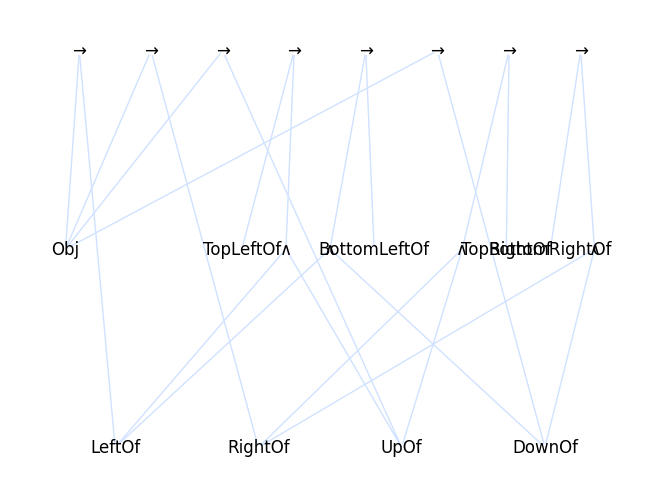

In [ ]:
model.plot_graph()

In [ ]:
LeftOf.state('3','4')

<Fact.UNKNOWN: (0.0, 1.0)>

In [ ]:
Obj.state('9')

<Fact.UNKNOWN: (0.0, 1.0)>

In [ ]:
RightOf.state('2','1')

<Fact.UNKNOWN: (0.0, 1.0)>

In [ ]:
model.infer()

(2, tensor(92.))

In [ ]:
model.print(source=top_left_relation)


***************************************************************************
                                LNN Model

AXIOM Implies: ((LeftOf(0, 1) ∧ UpOf(0, 1)) → TopLeftOf(0, 1)) 
('3', '4')                                                  TRUE (1.0, 1.0)
('4', '5')                                                  TRUE (1.0, 1.0)
('7', '3')                                                  TRUE (1.0, 1.0)
('4', '1')                                                  TRUE (1.0, 1.0)
('5', '7')                                                  TRUE (1.0, 1.0)
('6', '3')                                                  TRUE (1.0, 1.0)
('1', '7')                                                  TRUE (1.0, 1.0)
('5', '2')                                                  TRUE (1.0, 1.0)
('3', '3')                                                  TRUE (1.0, 1.0)
('6', '4')                                                  TRUE (1.0, 1.0)
('2', '7')                                              